In [1]:
import cv2
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics

%matplotlib inline

In [2]:
datagen= keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.25, #Split 75% for train and 25% for validation/test
    rescale=1./255 #Rescale the images
)

In [3]:
train_ds = datagen.flow_from_directory(
    'C:\\Users\\User\\Downloads\\archive\\dataset',
    target_size=(128, 128), #Target size
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

val_ds = datagen.flow_from_directory(
    'C:\\Users\\User\\Downloads\\archive\\dataset', # same directory as training data
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 5151 images belonging to 11 classes.
Found 1711 images belonging to 11 classes.


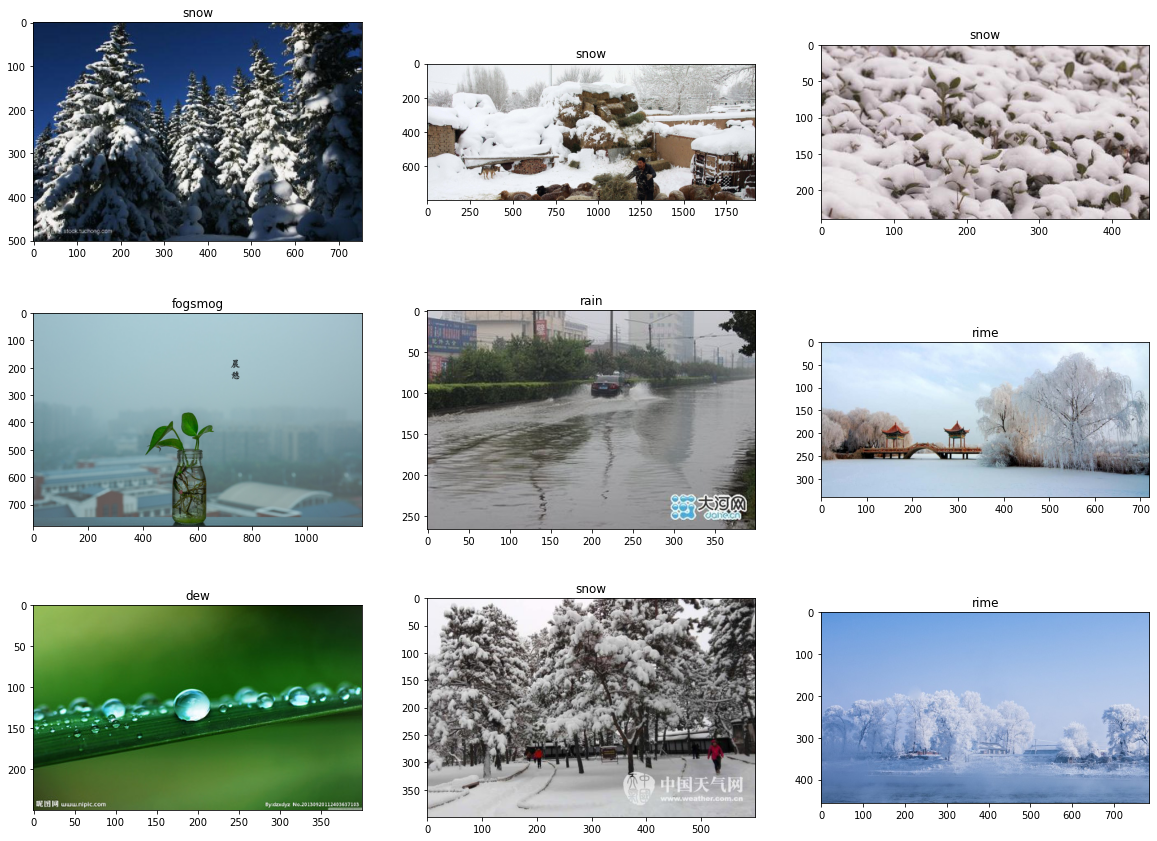

In [4]:
import random

fig, axes = plt.subplots(3,3, figsize=(20, 15))

indices_classes = {v: k for k, v in train_ds.class_indices.items()}
images_classes = list(zip(train_ds.filepaths, [indices_classes[k] for k in train_ds.classes]))
for ax in  axes.reshape(-1):
    random_image = random.choice(images_classes)
    img = mpimg.imread(random_image[0])
    ax.set_title(random_image[1])
    ax.imshow(img)

In [5]:
# Function to print the results of the fit process
def print_loss(result):
    plt.figure(figsize=(15,10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

In [6]:
# Dictionary to store all the evalute values from each neural network we test
predictions = {}

In [7]:
IMG_SHAPE = (128,128, 3)

base_model = keras.applications.ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = False

In [9]:
# Build the LeNET architecture
model = Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=IMG_SHAPE))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=11, activation='softmax'))         # At last layer sigmoid is used instead of softmax as it is a binary classification problem.

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 63, 63, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 30, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 120)               1

In [10]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

predictions['LeNET'] = model.evaluate(val_ds)

Epoch 1/100
161/161 [==============================] - 170s 1s/step - loss: 1.7001 - accuracy: 0.4310 - val_loss: 1.3118 - val_accuracy: 0.5763
Epoch 2/100
161/161 [==============================] - 207s 1s/step - loss: 1.2116 - accuracy: 0.5857 - val_loss: 1.1471 - val_accuracy: 0.6265
Epoch 3/100
161/161 [==============================] - 198s 1s/step - loss: 1.0271 - accuracy: 0.6589 - val_loss: 1.2116 - val_accuracy: 0.5903
Epoch 4/100
161/161 [==============================] - 206s 1s/step - loss: 0.8770 - accuracy: 0.7107 - val_loss: 0.9816 - val_accuracy: 0.6710
Epoch 5/100
161/161 [==============================] - 178s 1s/step - loss: 0.7357 - accuracy: 0.7577 - val_loss: 0.9880 - val_accuracy: 0.6698
Epoch 6/100
54/54 [==============================] - 44s 815ms/step - loss: 1.0670 - accuracy: 0.6645


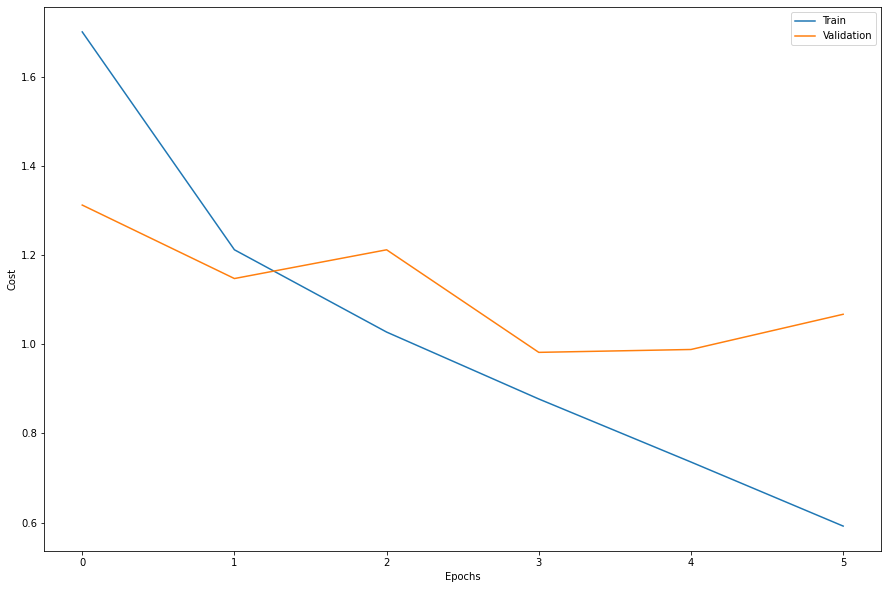

In [11]:
print_loss(history)

In [13]:
for prediction in predictions.items():
    print(f"""{prediction[0]}: {round((prediction[1][1] * 100),2)}%""")

LeNET: 66.45%
